In [36]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
import acquire
import prepare
import pandas as pd

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from prepare import prep_titanic

# Decision Tree

In [ ]:
#prep file is not working atm, going to do it by hand until I resolve the issue

In [3]:
df = pd.read_csv('titanic_df.csv')
df.head()

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [4]:
dummy1 = pd.get_dummies(df[['embark_town']],drop_first=True)
dummy2 = pd.get_dummies(df[['class']],drop_first=True)
df["is_female"] = (df.sex == "female")

In [5]:
df = pd.concat([df, dummy1, dummy2], axis=1)

In [6]:
df.head()

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0,False,0,1,0,1
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0,True,0,0,0,0
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1,True,0,1,0,1
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0,True,0,1,0,0
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1,False,0,1,0,1


In [7]:
df = df.drop(columns=['Unnamed: 0','passenger_id','age','sex', 'pclass','class', 'embarked','embark_town','deck','sibsp','parch'])

In [8]:
df.head()

,survived,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third
0,0,7.2500,0,False,0,1,0,1
1,1,71.2833,0,True,0,0,0,0
2,1,7.9250,1,True,0,1,0,1
3,1,53.1000,0,True,0,1,0,0
4,0,8.0500,1,False,0,1,0,1


In [11]:
df.dropna(inplace = True)
df.head()

,survived,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third
0,0,7.2500,0,False,0,1,0,1
1,1,71.2833,0,True,0,0,0,0
2,1,7.9250,1,True,0,1,0,1
3,1,53.1000,0,True,0,1,0,0
4,0,8.0500,1,False,0,1,0,1


In [12]:
def split(df, stratify_by=None):
    """
    Crude train, validate, test split
    To stratify, send in a column name for the stratify_by argument
    """

    if stratify_by == None:
        train, test = train_test_split(df, test_size=.2, random_state=123)
        train, validate = train_test_split(train, test_size=.3, random_state=123)
    else:
        train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[stratify_by])
        train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train[stratify_by])

    return train, validate, test

In [13]:
train, validate, test = split(df, stratify_by="survived")

In [14]:
#sanity check
train.shape, validate.shape, test.shape

((498, 8), (214, 8), (179, 8))

In [15]:
X_train, y_train = train.drop(columns='survived'), train.survived
X_validate, y_validate = validate.drop(columns='survived'), validate.survived
X_test, y_test = test.drop(columns='survived'), test.survived

In [17]:
train['baseline_prediction'] = 0 #because I'm predicting more people did not survive
accuracy_score(train.survived, train.baseline_prediction)

0.6164658634538153

Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [18]:
model1 = DecisionTreeClassifier()
model1.fit(X_train, y_train)

print(f'training score: {model1.score(X_train, y_train):.2%}')
print(f'validate score: {model1.score(X_validate, y_validate):.2%}')

training score: 93.78%
validate score: 76.64%


In [19]:
train['model1'] = model1.predict(X_train)
train.head()

,survived,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third,baseline_prediction,model1
583,0,40.1250,1,False,0,0,0,0,0,0
165,1,20.5250,0,False,0,1,0,1,0,0
50,0,39.6875,0,False,0,1,0,1,0,0
259,1,26.0000,0,True,0,1,1,0,0,1
306,1,110.8833,1,True,0,0,0,0,0,1


In [24]:
y_pred = model1.predict(X_train)

3.) Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [21]:
#using model score
model1.score(X_validate,y_validate)

0.7663551401869159

In [32]:
#confusion matrix
pd.crosstab(y_train, y_pred, normalize = True)

col_0,0,1
survived,,
0,0.612450,0.004016
1,0.058233,0.325301


In [27]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       307
           1       0.99      0.85      0.91       191

    accuracy                           0.94       498
   macro avg       0.95      0.92      0.93       498
weighted avg       0.94      0.94      0.94       498



4.) Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [38]:
#precision
sklearn.metrics.precision_score(y_train,y_pred)

0.9878048780487805

In [39]:
#recall
sklearn.metrics.recall_score(y_train,y_pred)

0.8481675392670157

In [40]:
#f1 score
.91

0.91

In [41]:
sklearn.metrics.f1_score(y_train,y_pred)

0.9126760563380283

5.) Run through steps 2-4 using a different max_depth value

In [43]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

0.7616822429906542


[Text(167.4, 181.2, 'X[2] <= 0.5\ngini = 0.473\nsamples = 498\nvalue = [307, 191]'),
 Text(83.7, 108.72, 'X[0] <= 18.275\ngini = 0.295\nsamples = 323\nvalue = [265, 58]'),
 Text(41.85, 36.23999999999998, 'gini = 0.184\nsamples = 205\nvalue = [184, 21]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.43\nsamples = 118\nvalue = [81, 37]'),
 Text(251.10000000000002, 108.72, 'X[6] <= 0.5\ngini = 0.365\nsamples = 175\nvalue = [42, 133]'),
 Text(209.25, 36.23999999999998, 'gini = 0.081\nsamples = 94\nvalue = [4, 90]'),
 Text(292.95, 36.23999999999998, 'gini = 0.498\nsamples = 81\nvalue = [38, 43]')]

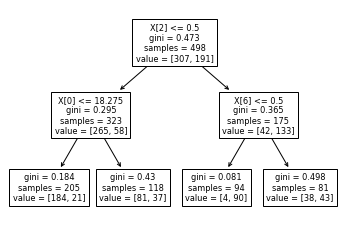

In [49]:
model2 = DecisionTreeClassifier(max_depth = 2)
model2.fit(X_train, y_train)
print(model2.score(X_validate,y_validate))
plot_tree(model2)

In [52]:
model2 = DecisionTreeClassifier(max_depth = 2)
model2.fit(X_train, y_train)

print(f'training score: {model2.score(X_train, y_train):.2%}')
print(f'validate score: {model2.score(X_validate, y_validate):.2%}')

training score: 79.92%
validate score: 76.17%


In [53]:
train['model2'] = model2.predict(X_train)
train.head()

,survived,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third,baseline_prediction,model1,model2
583,0,40.1250,1,False,0,0,0,0,0,0,0
165,1,20.5250,0,False,0,1,0,1,0,0,0
50,0,39.6875,0,False,0,1,0,1,0,0,0
259,1,26.0000,0,True,0,1,1,0,0,1,1
306,1,110.8833,1,True,0,0,0,0,0,1,1


In [54]:
y_pred = model2.predict(X_train)

In [55]:
pd.crosstab(y_train, y_pred, normalize = True)

col_0,0,1
survived,,
0,0.532129,0.084337
1,0.116466,0.267068


In [56]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       307
           1       0.76      0.70      0.73       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



In [ ]:
Accuracy = 76.6% 
TP Rate = 53%
FP = 5%
TN = 32.5%
FN = .4%

In [57]:
#will finish later



# Random Forest

Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [61]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [65]:
y_pred = rf.predict(X_train)

In [67]:
y_pred_proba = rf.predict_proba(X_train)

2.) Evaluate your results using the model score, confusion matrix, and classification report.

In [68]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.78


In [72]:
pd.crosstab(y_train, y_pred, margins = True)

col_0,0,1,All
survived,,,
0,301,6,307
1,26,165,191
All,327,171,498


In [79]:
tn = 301
tp = 165
fn = 26
fp = 6


In [70]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       307
           1       0.96      0.86      0.91       191

    accuracy                           0.94       498
   macro avg       0.94      0.92      0.93       498
weighted avg       0.94      0.94      0.93       498



3.) Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [76]:
print(f'accuracy score is {accuracy_score(y_train, y_pred)}')

accuracy score is 0.9357429718875502


In [81]:
print(f'true positive rate is {tp / (tn + tp+fn+fp)}')

true positive rate is 0.3313253012048193


In [82]:
print(f'true negative rate is {tn / (tn + tp+fn+fp)}')

true negative rate is 0.6044176706827309


In [83]:
print(f'false positive rate is {fp / (tn + tp+fn+fp)}')

false positive rate is 0.012048192771084338


In [85]:
print(f'false negative rate is {fn / (tn + tp+fn+fp)}')

false negative rate is 0.05220883534136546


In [87]:
print(f'recall score is {sklearn.metrics.recall_score(y_train, y_pred)}')

recall score is 0.8638743455497382


In [88]:
print(f'precision score is {sklearn.metrics.precision_score(y_train, y_pred)}')

precision score is 0.9649122807017544


In [89]:
print(f'f1 score is {sklearn.metrics.f1_score(y_train, y_pred)}')

f1 score is 0.9116022099447514


4.) Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [90]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=5,
                            n_estimators=100,
                            max_depth=7, 
                            random_state=123)

In [91]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, random_state=123)

In [92]:
y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)

In [93]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.79


In [94]:
pd.crosstab(y_train, y_pred, margins = True)

col_0,0,1,All
survived,,,
0,295,12,307
1,63,128,191
All,358,140,498


In [95]:
tn = 295
tp = 128
fn = 63
fp = 12

In [96]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       307
           1       0.91      0.67      0.77       191

    accuracy                           0.85       498
   macro avg       0.87      0.82      0.83       498
weighted avg       0.86      0.85      0.84       498



In [97]:
print(f'accuracy score is {accuracy_score(y_train, y_pred)}')
print(f'true positive rate is {tp / (tn + tp+fn+fp)}')
print(f'true negative rate is {tn / (tn + tp+fn+fp)}')
print(f'false positive rate is {fp / (tn + tp+fn+fp)}')
print(f'false negative rate is {fn / (tn + tp+fn+fp)}')
print(f'recall score is {sklearn.metrics.recall_score(y_train, y_pred)}')
print(f'precision score is {sklearn.metrics.precision_score(y_train, y_pred)}')
print(f'f1 score is {sklearn.metrics.f1_score(y_train, y_pred)}')

accuracy score is 0.8493975903614458
true positive rate is 0.2570281124497992
true negative rate is 0.5923694779116466
false positive rate is 0.024096385542168676
false negative rate is 0.12650602409638553
recall score is 0.6701570680628273
precision score is 0.9142857142857143
f1 score is 0.7734138972809668


In [98]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=100,
                            n_estimators=100,
                            max_depth=20, 
                            random_state=123)

In [99]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.76


In [100]:
pd.crosstab(y_train, y_pred, margins = True)

col_0,0,1,All
survived,,,
0,280,27,307
1,83,108,191
All,363,135,498


In [101]:
tn = 280
tp = 108
fn = 83
fp = 27

In [102]:
print(f'accuracy score is {accuracy_score(y_train, y_pred)}')
print(f'true positive rate is {tp / (tn + tp+fn+fp)}')
print(f'true negative rate is {tn / (tn + tp+fn+fp)}')
print(f'false positive rate is {fp / (tn + tp+fn+fp)}')
print(f'false negative rate is {fn / (tn + tp+fn+fp)}')
print(f'recall score is {sklearn.metrics.recall_score(y_train, y_pred)}')
print(f'precision score is {sklearn.metrics.precision_score(y_train, y_pred)}')
print(f'f1 score is {sklearn.metrics.f1_score(y_train, y_pred)}')

accuracy score is 0.7791164658634538
true positive rate is 0.21686746987951808
true negative rate is 0.5622489959839357
false positive rate is 0.05421686746987952
false negative rate is 0.16666666666666666
recall score is 0.5654450261780105
precision score is 0.8
f1 score is 0.6625766871165645


In [103]:
rf.score(X_validate,y_validate)

0.7616822429906542

5.) What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?